In [3]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error

import xgboost as xgb

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [5]:
df = pd.read_csv("hourly-energy-consumption/PJME_hourly.csv")
df = df.set_index("Datetime")
df.index = pd.to_datetime(df.index)
df = df.sort_index()

In [6]:
df.head()

,PJME_MW
Datetime,
2002-01-01 01:00:00,30393.0
2002-01-01 02:00:00,29265.0
2002-01-01 03:00:00,28357.0
2002-01-01 04:00:00,27899.0
2002-01-01 05:00:00,28057.0


In [6]:
df.tail()

,PJME_MW
Datetime,
2018-08-02 20:00:00,44057.0
2018-08-02 21:00:00,43256.0
2018-08-02 22:00:00,41552.0
2018-08-02 23:00:00,38500.0
2018-08-03 00:00:00,35486.0


<Axes: title={'center': 'PJME Energy Use in MW'}, xlabel='Datetime'>

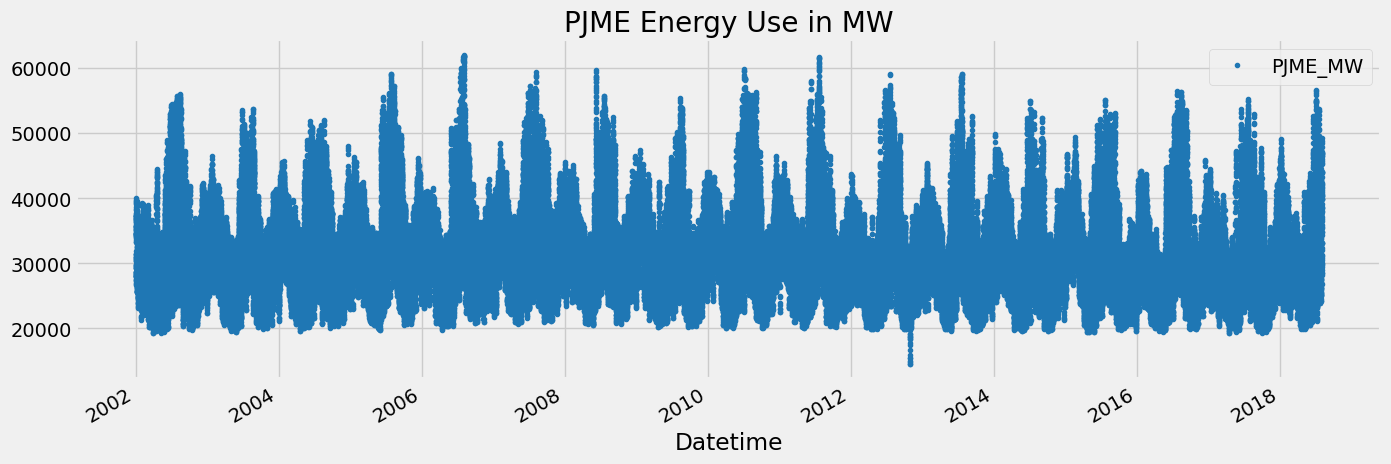

In [7]:
df.plot(style=".",
        figsize=(15,5),
        color=color_pal[0],
        title="PJME Energy Use in MW")

In [8]:
train = df.loc[df.index < "01-01-2015"]
test = df.loc[df.index >= "01-01-2015"]

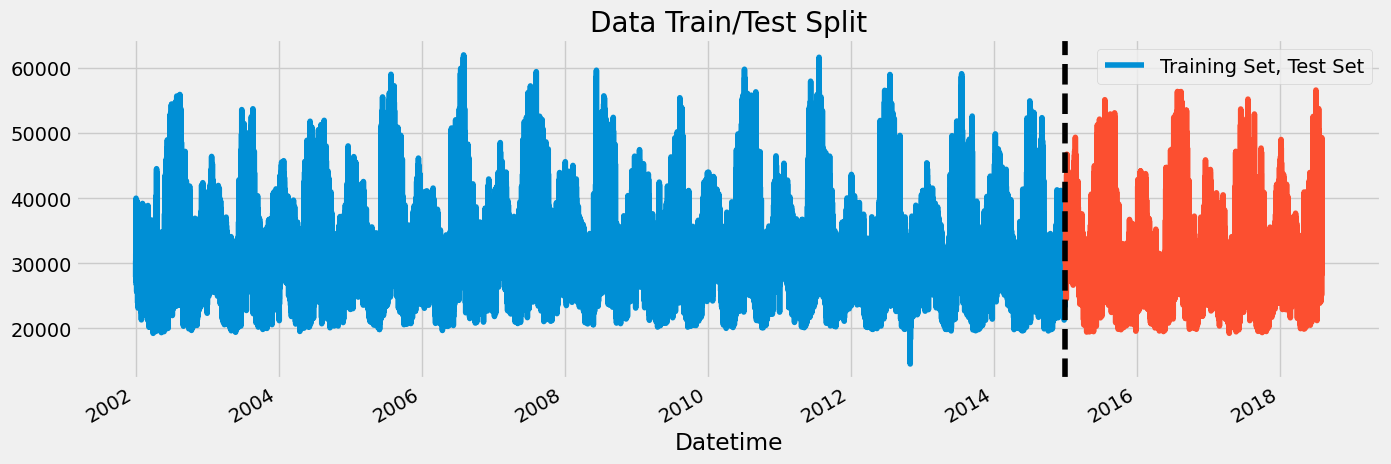

In [9]:
fig, ax = plt.subplots(figsize=(15,5))

train.plot(ax=ax, label="Training Set", title="Data Train/Test Split")
test.plot(ax=ax, label="Test Set")

ax.axvline("01-01-2015", color="black", ls="--")
ax.legend(["Training Set, Test Set"])

<Axes: title={'center': 'Week of Data'}, xlabel='Datetime'>

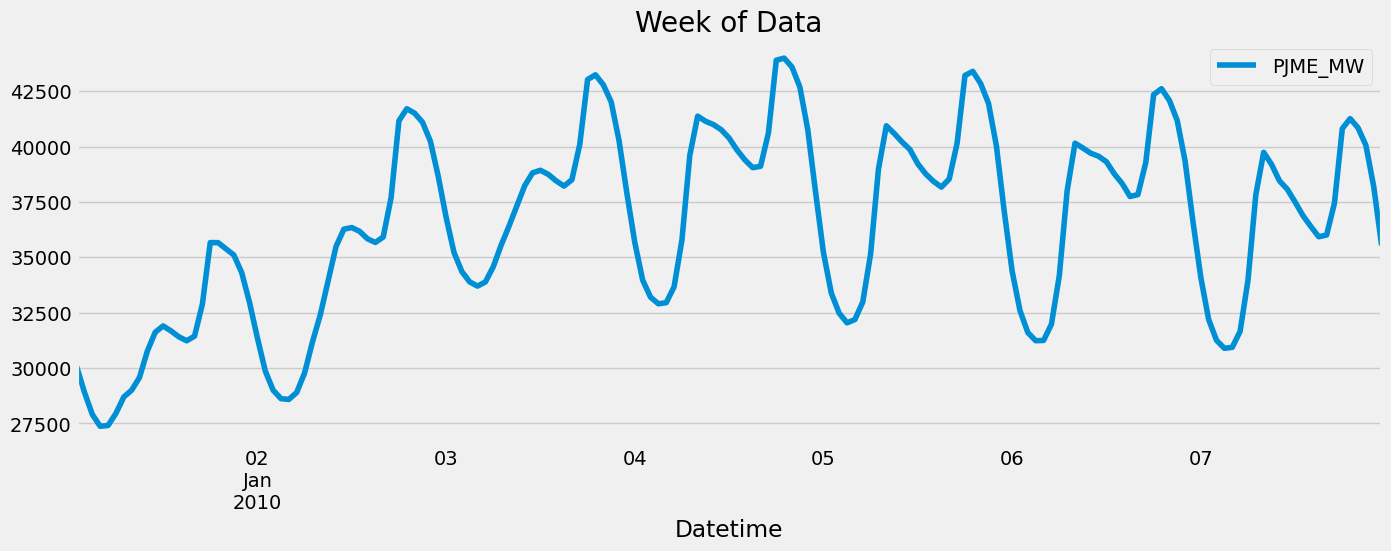

In [10]:
df.loc[(df.index > "01-01-2010") & (df.index < "01-08-2010")].plot(figsize=(15,5), title="Week of Data")

In [11]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()

    df["hour"] = df.index.hour
    df["dayofweek"] = df.index.dayofweek
    df["quarter"] = df.index.quarter
    df["month"] = df.index.month
    df["year"] = df.index.year
    df["dayofyear"] = df.index.dayofyear

    return df

In [12]:
df = create_features(df=df)

In [13]:
df.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear
Datetime,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1


Text(0.5, 1.0, 'MW by Hour')

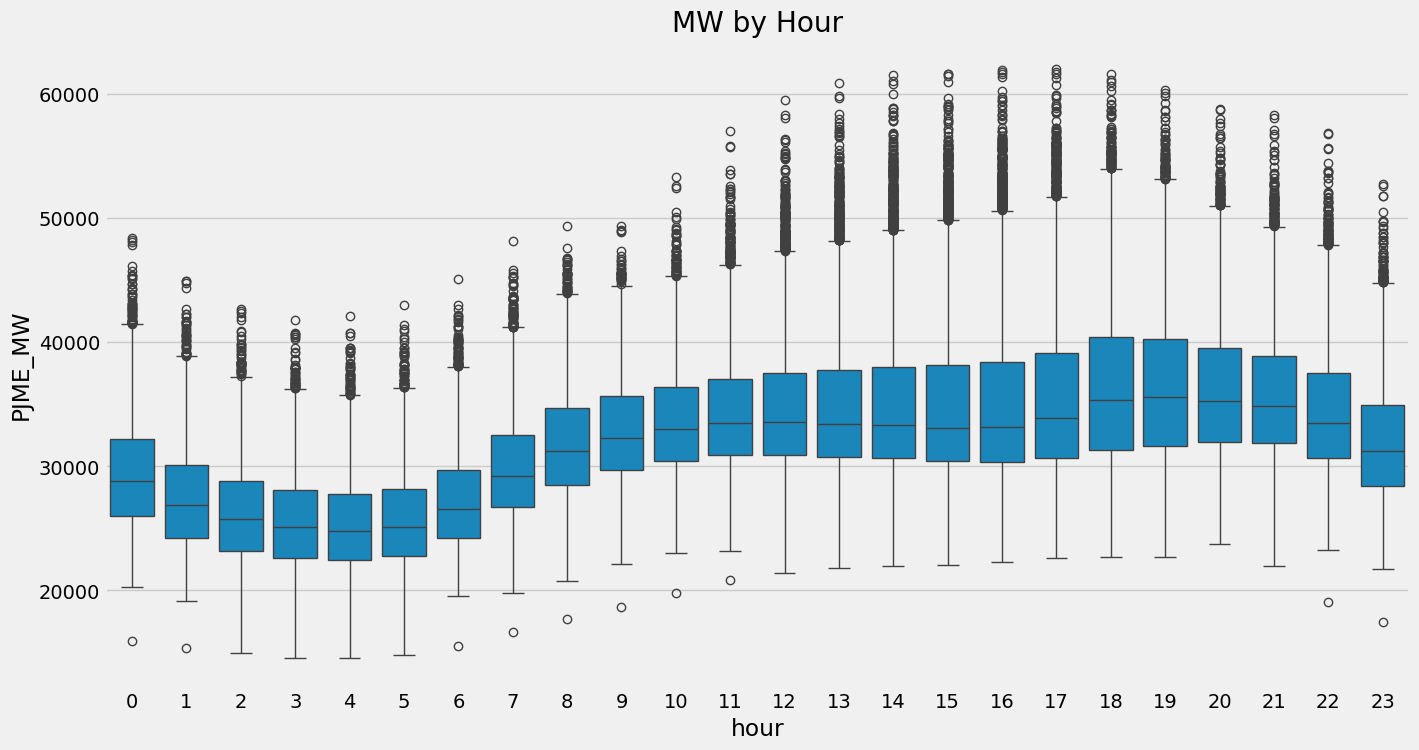

In [14]:
fig, ax = plt.subplots(figsize=(15,8))

sns.boxplot(data=df, x="hour", y="PJME_MW")

ax.set_title("MW by Hour")

Text(0.5, 1.0, 'MW by Month')

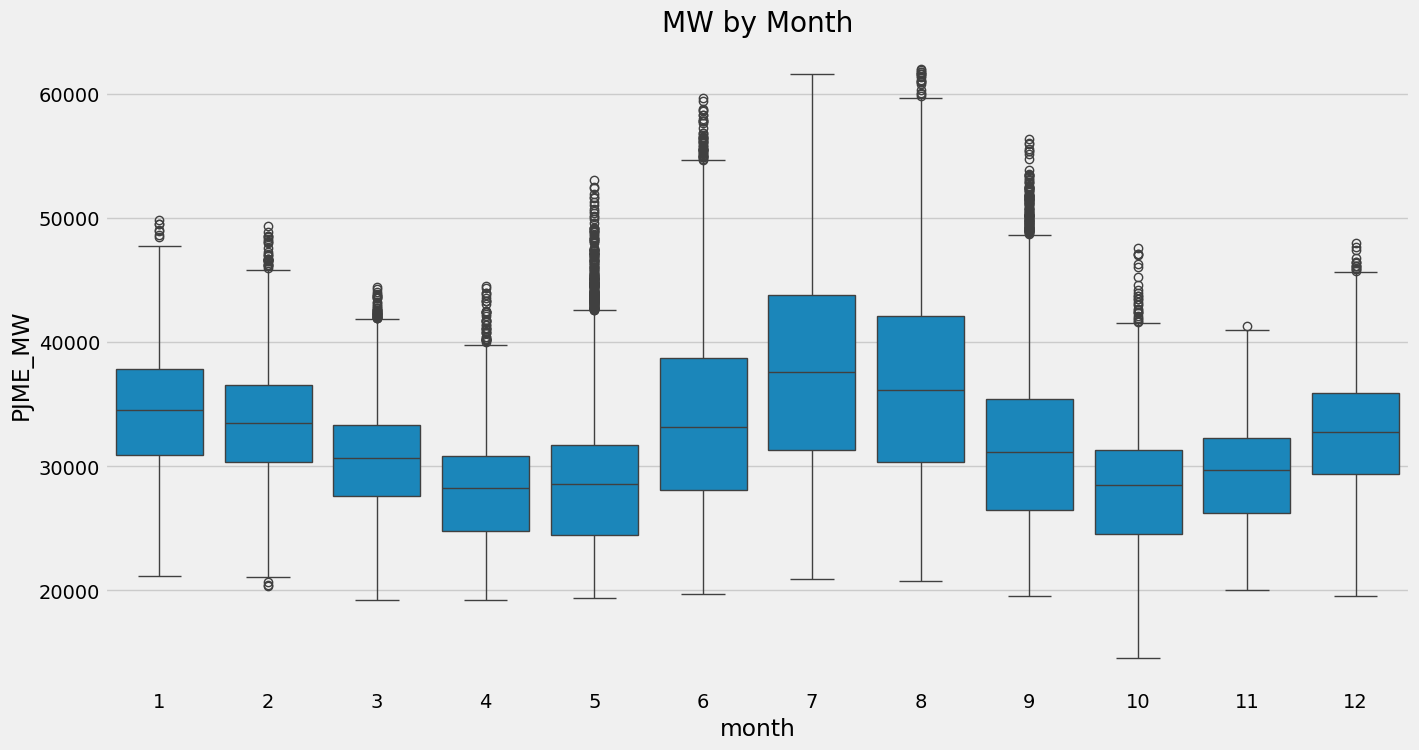

In [15]:
fig, ax = plt.subplots(figsize=(15,8))

sns.boxplot(data=df, x="month", y="PJME_MW")

ax.set_title("MW by Month")

In [16]:
train = create_features(train)
test = create_features(test)

FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear']
TARGET = ['PJME_MW']

In [17]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [18]:
reg = xgb.XGBRegressor(n_estimators=5000,
                       early_stopping_rounds=50,
                       learning_rate=0.001,
                       n_jobs=-1)

reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train),(X_test, y_test)],
        verbose=300)

[0]	validation_0-rmse:6447.78573	validation_1-rmse:6517.54145
[300]	validation_0-rmse:5326.88030	validation_1-rmse:5505.59274
[600]	validation_0-rmse:4565.97498	validation_1-rmse:4847.76655
[900]	validation_0-rmse:4055.65261	validation_1-rmse:4427.00726
[1200]	validation_0-rmse:3716.06486	validation_1-rmse:4172.78015
[1500]	validation_0-rmse:3486.27749	validation_1-rmse:4017.25069
[1800]	validation_0-rmse:3329.61423	validation_1-rmse:3914.32646
[2100]	validation_0-rmse:3215.72862	validation_1-rmse:3846.53268
[2400]	validation_0-rmse:3126.67303	validation_1-rmse:3796.76801
[2700]	validation_0-rmse:3056.93602	validation_1-rmse:3763.83068
[3000]	validation_0-rmse:3001.29640	validation_1-rmse:3748.80686
[3300]	validation_0-rmse:2954.33666	validation_1-rmse:3741.10811
[3600]	validation_0-rmse:2907.61751	validation_1-rmse:3737.57285
[3611]	validation_0-rmse:2905.59740	validation_1-rmse:3737.58173


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,50
,enable_categorical,False
,eval_metric,None


In [19]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=["importance"])

<Axes: title={'center': 'Feature Importance'}>

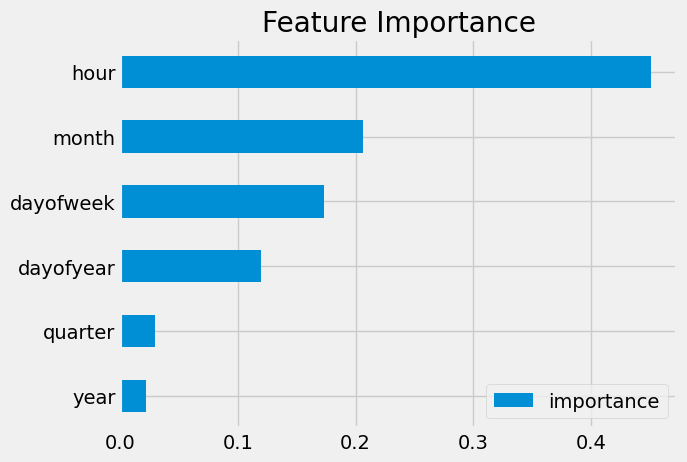

In [20]:
fi.sort_values("importance").plot(kind="barh", title="Feature Importance")

In [21]:
test["prediction"] = reg.predict(X_test)
df = df.merge(test[["prediction"]], how="left", left_index=True, right_index=True)

Text(0.5, 1.0, 'Raw Data and Predictions')

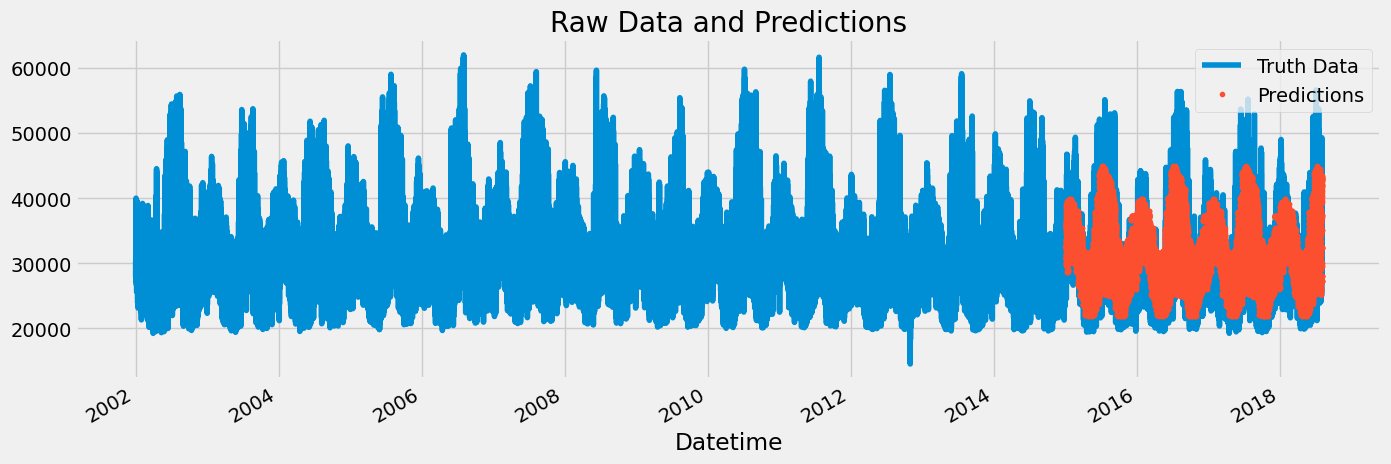

In [22]:
ax = df[["PJME_MW"]].plot(figsize=(15,5))
df["prediction"].plot(ax=ax, style=".")

plt.legend(["Truth Data", "Predictions"])
ax.set_title("Raw Data and Predictions")

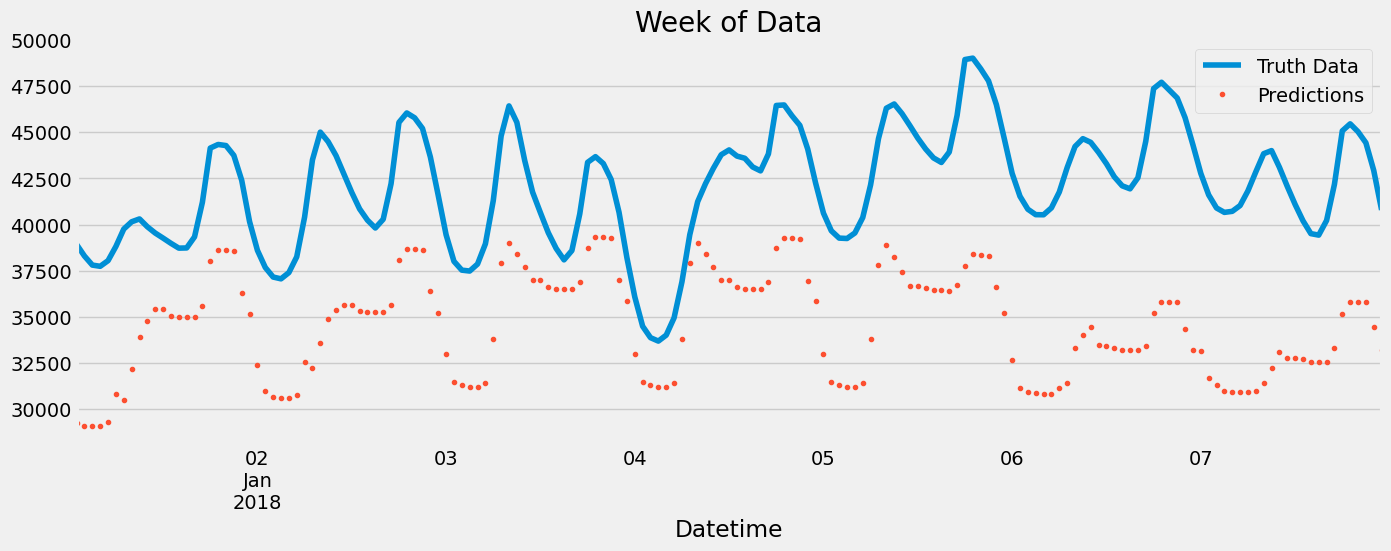

In [23]:
ax = df.loc[(df.index > "01-01-2018") & (df.index < "01-08-2018")]["PJME_MW"] \
    .plot(figsize=(15,5), title="Week of Data")
df.loc[(df.index > "01-01-2018") & (df.index < "01-08-2018")]["prediction"] \
    .plot(style=".")

plt.legend(["Truth Data", "Predictions"])

In [24]:
score = np.sqrt(mean_squared_error(test["PJME_MW"], test["prediction"]))
print(f"RMSE Score on Test Set: {score:0.2f}")

RMSE Score on Test Set: 3737.28


In [31]:
test["error"] = np.abs(test["PJME_MW"] - test["prediction"])

In [32]:
test["date"] = test.index.date

In [37]:
test.groupby("date")["error"].mean().sort_values(ascending=False).head(10)

date
2016-08-13    13647.170410
2016-08-14    13380.040202
2016-09-10    11303.504069
2016-09-09    11122.334717
2016-08-12    10533.937744
2018-01-06    10434.996501
2015-02-20    10167.829102
2016-07-04     9438.706624
2017-05-19     9420.591146
2018-01-07     9360.098470
Name: error, dtype: float64